In [33]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()

In [4]:
NUM_LENGTH_QUANTILES = 15

# render the expensive figures?
RENDER_ALL_FIGURES = True

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# save figures?
FIGURE_DIR = RESULTS_DIR / "figures"
FIGURE_DIR.mkdir(exist_ok=True)
SAVE_FIGURES = True

## Code suite metadata

In [5]:
# Format: suite_first_token -> [((expected_grammatical_region, expected_grammatical_condition),
#                                (expected_ungrammatical_region, expected_ungrammatical_condition), ...]
# 
# Will be used to compute margins between region-condition values.
# NB these are 1 greater than the region numbers in the SyntaxGym suites because each suite has an additional
# prefix region (possibly empty) at the start.

margin_measures = {
    "fgd_pp": [((8, "that_nogap"), (8, "what_nogap")),
               ((9, "what_gap"), (9, "that_gap"))],
    "fgd_subject": [((4, "that_nogap"), (4, "what_nogap")),
                    ((5, "what_gap"), (5, "that_gap"))],
    "fgd_object": [((6, "that_nogap"), (6, "what_nogap")),
                   ((7, "what_gap"), (7, "that_gap"))],

    "npi": [((9, "neg_pos"), (9, "pos_pos")),
            ((9, "neg_neg"), (9, "pos_neg")),
            ((9, "neg_pos"), (9, "pos_neg"))],

    # NB missing interaction term because we can't phrase it in this language
    "npz_obj": [((6, "no-obj_comma"), (6, "no-obj_no-comma")),
                ((6, "obj_no-comma"), (6, "no-obj_no-comma"))],
    "npz_obj_mod": [((7, "no-obj_comma"), (7, "no-obj_no-comma")),
                    ((7, "obj_no-comma"), (7, "no-obj_no-comma"))],
    
    "number_prep": [((7, "match_sing"), (7, "mismatch_sing")),
                    ((7, "match_plural"), (7, "mismatch_plural"))],
    "number_src": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],
    "number_orc": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],

    "reflexive_prep_fem": [((8, "match_sing"), (8, "mismatch_sing")),
                           ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_prep_masc": [((8, "match_sing"), (8, "mismatch_sing")),
                            ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    
    "subordination_src-src": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_orc-orc": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_pp-pp": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                            ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    
    "mvrr": [((6, "unreduced_ambig"), (6, "reduced_ambig")),
             ((6, "reduced_unambig"), (6, "reduced_ambig"))],
}

In [6]:
critical_regions = {suite: set(region for region_comparison in region_comparisons for region in region_comparison)
                    for suite, region_comparisons in margin_measures.items()}
critical_region_strs = {suite: {" ".join(map(str, region)) for region in regions} for suite, regions in critical_regions.items()}
critical_region_strs

{'fgd_pp': {'8 that_nogap', '8 what_nogap', '9 that_gap', '9 what_gap'},
 'fgd_subject': {'4 that_nogap', '4 what_nogap', '5 that_gap', '5 what_gap'},
 'fgd_object': {'6 that_nogap', '6 what_nogap', '7 that_gap', '7 what_gap'},
 'npi': {'9 neg_neg', '9 neg_pos', '9 pos_neg', '9 pos_pos'},
 'npz_obj': {'6 no-obj_comma', '6 no-obj_no-comma', '6 obj_no-comma'},
 'npz_obj_mod': {'7 no-obj_comma', '7 no-obj_no-comma', '7 obj_no-comma'},
 'number_prep': {'7 match_plural',
  '7 match_sing',
  '7 mismatch_plural',
  '7 mismatch_sing'},
 'number_src': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'number_orc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_prep_fem': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_orc_fem': {'9 match_plural',
  '9 match_sing',
  '9

## Load results

In [8]:
OUTPUT_DIR = Path("output")

In [9]:
prediction_paths = list(OUTPUT_DIR.glob("*/**/*/*/predictions.csv"))
prediction_dfs = [pd.read_csv(path) for path in tqdm(prediction_paths)]
prediction_df_keys = [re.findall(r"([^/]+)/([^/]+)/([^/]+)/([^/]+)/predictions\.csv", str(path))[0]
                      for path in prediction_paths]
prediction_df = pd.concat(prediction_dfs, names=["model", "prefix_type", "suite", "prefix_suite"], keys=prediction_df_keys) \
    .drop(columns=["prefix_suite"])

# Drop duplicates
prediction_df = prediction_df[~prediction_df.index.duplicated(keep="first")]

  0%|          | 0/4662 [00:00<?, ?it/s]

In [10]:
# Limit data to a prefix length where all prefix suites have appropriate data.
length_limit = prediction_df.groupby("prefix_suite").prefix_length.max().min()

len_before = len(prediction_df)
prediction_df = prediction_df[prediction_df.prefix_length <= length_limit]
len_after = len(prediction_df)
print(f"Dropped unbalanced-ly long examples, {len_before} -> {len_after} (-{((len_before - len_after) / len_before * 100):.2f}%)")

Dropped unbalanced-ly long examples, 9267000 -> 6926567 (-25.26%)


In [11]:
# Metadata variables that should be propagated from prediction_df to other derived and associated dfs
meta_vars = ["num_prefix_sentences", "prefix_length", "prefix_length_bin_left", "prefix_length_bin_mid", "prefix_length_bin_right",
             "canonical_suite", "suite_category", "item_number"]

prediction_cols = [key for key in prediction_df.columns if key.startswith("prediction_")]
prediction_df["prediction_ALL"] = prediction_df[prediction_cols].all(axis=1)
prediction_cols += ["prediction_ALL"]

prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)

canonical_suite = {suite_name: next(can_suite for can_suite in critical_regions.keys()
                                    if can_suite in suite_name)
                   for suite_name in set(prediction_df.index.get_level_values("suite"))}

prediction_df["canonical_suite"] = prediction_df.index.get_level_values("suite").map(canonical_suite)
prediction_df["suite_category"] = prediction_df.canonical_suite.str.split("_").apply(lambda parts: "_".join(parts[:-1]) if len(parts) > 1 else parts[0])
prediction_df["critical_region"] = prediction_df.canonical_suite.map(critical_regions)

In [12]:
prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
prefix_length_bin = pd.arrays.IntervalArray(pd.qcut(prediction_df.prefix_length, NUM_LENGTH_QUANTILES))
prediction_df["prefix_length_bin_left"] = prefix_length_bin.left
prediction_df["prefix_length_bin_mid"] = prefix_length_bin.mid
prediction_df["prefix_length_bin_right"] = prefix_length_bin.right

In [13]:
prediction_df = prediction_df.reset_index()

In [10]:
region_paths = list(OUTPUT_DIR.glob("*/*/*/*/regions.csv"))
region_dfs = [pd.read_csv(path) for path in tqdm(region_paths)]
region_df_keys = [re.findall(r"([^/]+)/([^/]+)/([^/]+)/([^/]+)/regions\.csv", str(path))[0]
                   for path in region_paths]
region_df = pd.concat(region_dfs, names=["model", "prefix_type", "suite", "prefix_suite"], keys=region_df_keys) \
    .drop(columns=["prefix_suite"])

  0%|          | 0/941 [00:00<?, ?it/s]

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Drop duplicates
region_df = region_df[~region_df.index.duplicated(keep="first")]

# Bring in metadata from predictions df
region_df = pd.merge(region_df.reset_index(), prediction_df[meta_vars].reset_index(),
                     on=["model", "prefix_type", "suite", "prefix_suite", "item_number"])

region_df

In [78]:
sns.set_context("talk")

## Prediction results

In [14]:
# Get baseline accuracy results.
baseline_accuracies = prediction_df[prediction_df.used_conditions.isna()] \
    [prediction_cols + ["canonical_suite", "model"]] \
    .melt(id_vars=["canonical_suite", "model"]).groupby(["canonical_suite", "model", "variable"]).value.mean().dropna()
baseline_accuracies

canonical_suite        model     variable      
fgd_object             gpt2      prediction_0      1.000000
                                 prediction_1      0.958333
                                 prediction_ALL    0.958333
                       opt-1.3b  prediction_0      1.000000
                                 prediction_1      0.958333
                                                     ...   
subordination_src-src  opt-350m  prediction_1      1.000000
                                 prediction_ALL    0.869565
                       opt-6.7b  prediction_0      1.000000
                                 prediction_1      0.974359
                                 prediction_ALL    0.974359
Name: value, Length: 285, dtype: float64

In [15]:
prediction_df_melt = prediction_df.loc[:, prediction_df.columns.str.startswith(("model", "prediction", "prefix_type", "prefix_suite") + tuple(meta_vars))] \
    .melt(id_vars=meta_vars + ["model", "prefix_type", "prefix_suite"], var_name="prediction", value_name="correct")
prediction_df_melt

,num_prefix_sentences,prefix_length,prefix_length_bin_left,prefix_length_bin_mid,prefix_length_bin_right,canonical_suite,suite_category,item_number,model,prefix_type,prefix_suite,prediction,correct
0,0.0,0,-0.001,9.9995,20.0,fgd_object,fgd,1,opt-1.3b,grammatical,fgd_object,prediction_0,True
1,0.0,0,-0.001,9.9995,20.0,fgd_object,fgd,2,opt-1.3b,grammatical,fgd_object,prediction_0,True
2,0.0,0,-0.001,9.9995,20.0,fgd_object,fgd,3,opt-1.3b,grammatical,fgd_object,prediction_0,True
3,0.0,0,-0.001,9.9995,20.0,fgd_object,fgd,4,opt-1.3b,grammatical,fgd_object,prediction_0,True
4,0.0,0,-0.001,9.9995,20.0,fgd_object,fgd,5,opt-1.3b,grammatical,fgd_object,prediction_0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27706263,14.0,286,273.000,281.5000,290.0,subordination_src-src,subordination,1154,gpt2,ungrammatical,subordination_src-src,prediction_ALL,False
27706264,14.0,281,273.000,281.5000,290.0,subordination_src-src,subordination,1160,gpt2,ungrammatical,subordination_src-src,prediction_ALL,True
27706265,14.0,284,273.000,281.5000,290.0,subordination_src-src,subordination,1164,gpt2,ungrammatical,subordination_src-src,prediction_ALL,True
27706266,14.0,290,273.000,281.5000,290.0,subordination_src-src,subordination,1167,gpt2,ungrammatical,subordination_src-src,prediction_ALL,False


In [16]:
# Compute average accuracies per model/prefix suite/suite/prefix type/prediction/prefix length bin.
prediction_summaries = pd.DataFrame(prediction_df_melt.dropna().groupby(["model", "prefix_type", "canonical_suite", "prefix_suite", "prefix_length_bin_mid", "prediction"]).correct.mean())
# Merge in baseline information.
merged = pd.merge(prediction_summaries, baseline_accuracies.rename("baseline_accuracy").rename_axis(index={"variable": "prediction"}),
                  left_index=True, right_index=True, how="outer")
assert len(merged) == len(prediction_summaries)
prediction_summaries = merged.reset_index()

In [17]:
prediction_summaries["baselined"] = prediction_summaries.correct - prediction_summaries.baseline_accuracy
prediction_summaries["in_domain"] = prediction_summaries.prefix_suite == prediction_summaries.canonical_suite
prediction_summaries["strategy"] = prediction_summaries.prefix_type.str.cat(prediction_summaries.in_domain.map({True: "in-domain", False: "out-of-domain"}), sep=" ")
prediction_summaries

,model,canonical_suite,prediction,prefix_type,prefix_suite,prefix_length_bin_mid,correct,baseline_accuracy,baselined,in_domain,strategy
0,gpt2,fgd_object,prediction_0,grammatical,fgd_object,9.9995,1.000000,1.000000,0.000000,True,grammatical in-domain
1,gpt2,fgd_object,prediction_0,grammatical,fgd_object,30.0000,1.000000,1.000000,0.000000,True,grammatical in-domain
2,gpt2,fgd_object,prediction_0,grammatical,fgd_object,49.5000,1.000000,1.000000,0.000000,True,grammatical in-domain
3,gpt2,fgd_object,prediction_0,grammatical,fgd_object,69.0000,1.000000,1.000000,0.000000,True,grammatical in-domain
4,gpt2,fgd_object,prediction_0,grammatical,fgd_object,88.0000,1.000000,1.000000,0.000000,True,grammatical in-domain
...,...,...,...,...,...,...,...,...,...,...,...
174400,opt-6.7b,subordination_src-src,prediction_ALL,ungrammatical,subordination_orc-orc,204.0000,0.644737,0.974359,-0.329622,False,ungrammatical out-of-domain
174401,opt-6.7b,subordination_src-src,prediction_ALL,ungrammatical,subordination_orc-orc,223.5000,0.597561,0.974359,-0.376798,False,ungrammatical out-of-domain
174402,opt-6.7b,subordination_src-src,prediction_ALL,ungrammatical,subordination_orc-orc,243.0000,0.578947,0.974359,-0.395412,False,ungrammatical out-of-domain
174403,opt-6.7b,subordination_src-src,prediction_ALL,ungrammatical,subordination_orc-orc,263.0000,0.519481,0.974359,-0.454878,False,ungrammatical out-of-domain


In [18]:
prediction_summaries.to_csv("prediction_summaries.csv")

In [19]:
prediction_summaries[prediction_summaries.in_domain].groupby(["strategy", "prefix_length_bin_mid"]).size()

strategy                 prefix_length_bin_mid
grammatical in-domain    9.9995                   250
                         30.0000                  250
                         49.5000                  250
                         69.0000                  250
                         88.0000                  250
                         107.0000                 250
                         127.0000                 250
                         146.0000                 250
                         165.5000                 250
                         185.0000                 250
                         204.0000                 250
                         223.5000                 250
                         243.0000                 250
                         263.0000                 250
                         281.5000                 250
ungrammatical in-domain  9.9995                   216
                         30.0000                  216
                         49.5000   

In [ ]:
# Test effect of wikipedia prefixing
# on only grammatical data

# acc ~ is_wikipedia * prefix_length + (grammatical * prefix_length | suite)

In [53]:
# acc ~ grammatical * indomain * prefix_length + (grammatical * prefix_length | suite)
#
# prefix type (grammatical +1, ungrammatical -1)
# indomain (out -1, in 1)
# prefix_length
# prefix_length * in_domain
# ...

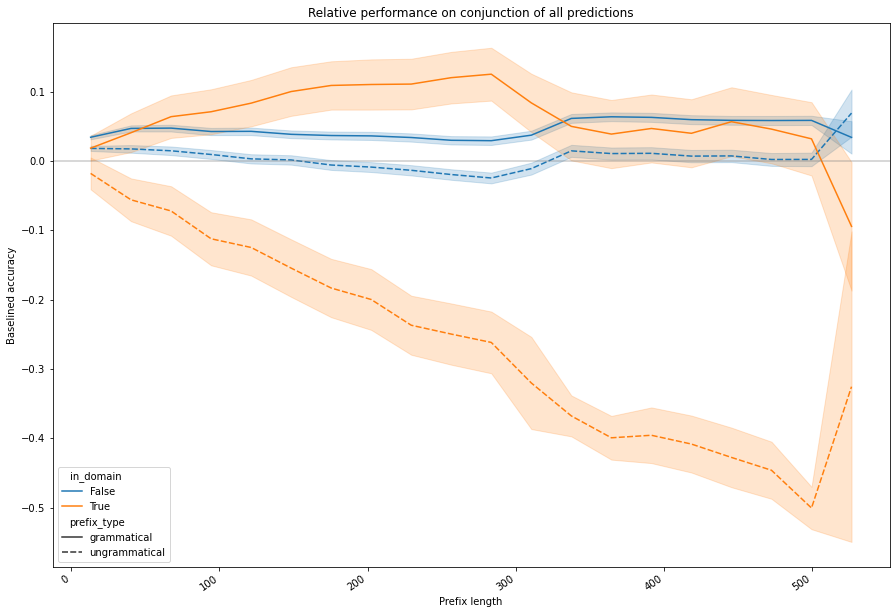

In [27]:
plt.subplots(figsize=(15, 10))
ax = sns.lineplot(data=prediction_summaries[prediction_summaries.prediction == "prediction_ALL"],
                  x="prefix_length_bin_mid", y="baselined", hue="in_domain", style="prefix_type",
                  errorbar="se")
plt.ylabel("Baselined accuracy")
plt.xlabel("Prefix length")
plt.title("Relative performance on conjunction of all predictions")
plt.xticks(rotation=35, ha="right")
plt.axhline(0, alpha=0.4, color="gray")

# in_domain_prefixes = prediction_df_melt[prediction_df_melt.prefix_suite == prediction_df_melt.canonical_suite]
# sns.lineplot(data=in_domain_prefixes, x="prefix_length_bin", y="correct", errorbar="se")


# main effect of grammaticality: WHAT DOES THIS MEAN?
# priming in-domain, anti-priming in-domain: interaction of in-domain : grammatical
# in-domain vs out-of-domain effect size: three-way interaction

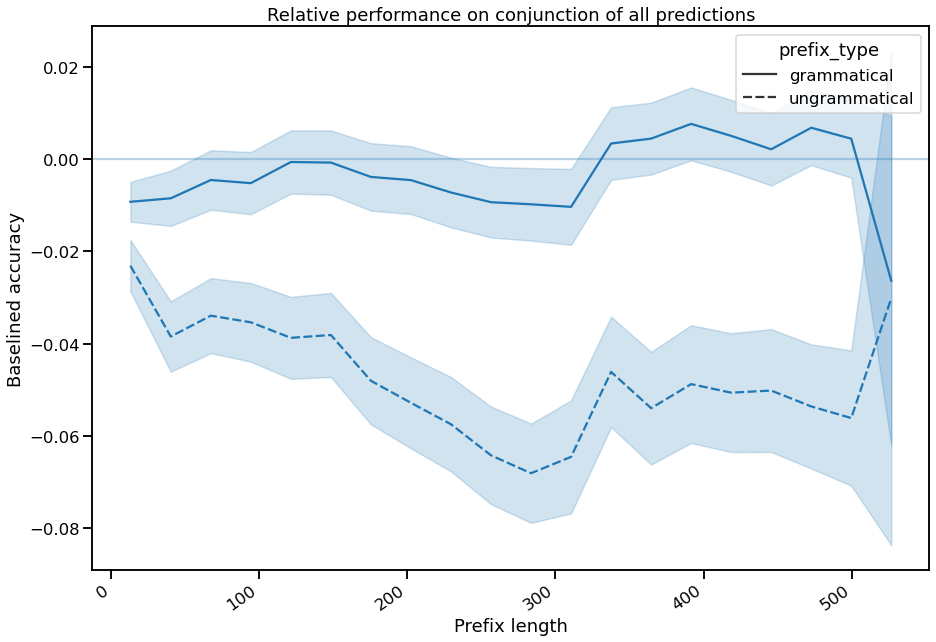

In [51]:
plt.subplots(figsize=(15, 10))
ax = sns.lineplot(data=prediction_summaries[prediction_summaries.prediction == "prediction_ALL"],
                  x="prefix_length_bin_mid", y="baselined", style="prefix_type",
                  errorbar="se")
plt.ylabel("Baselined accuracy")
plt.xlabel("Prefix length")
plt.title("Relative performance on conjunction of all predictions")
plt.xticks(rotation=35, ha="right")
plt.axhline(0, alpha=0.3)

### By-suite results

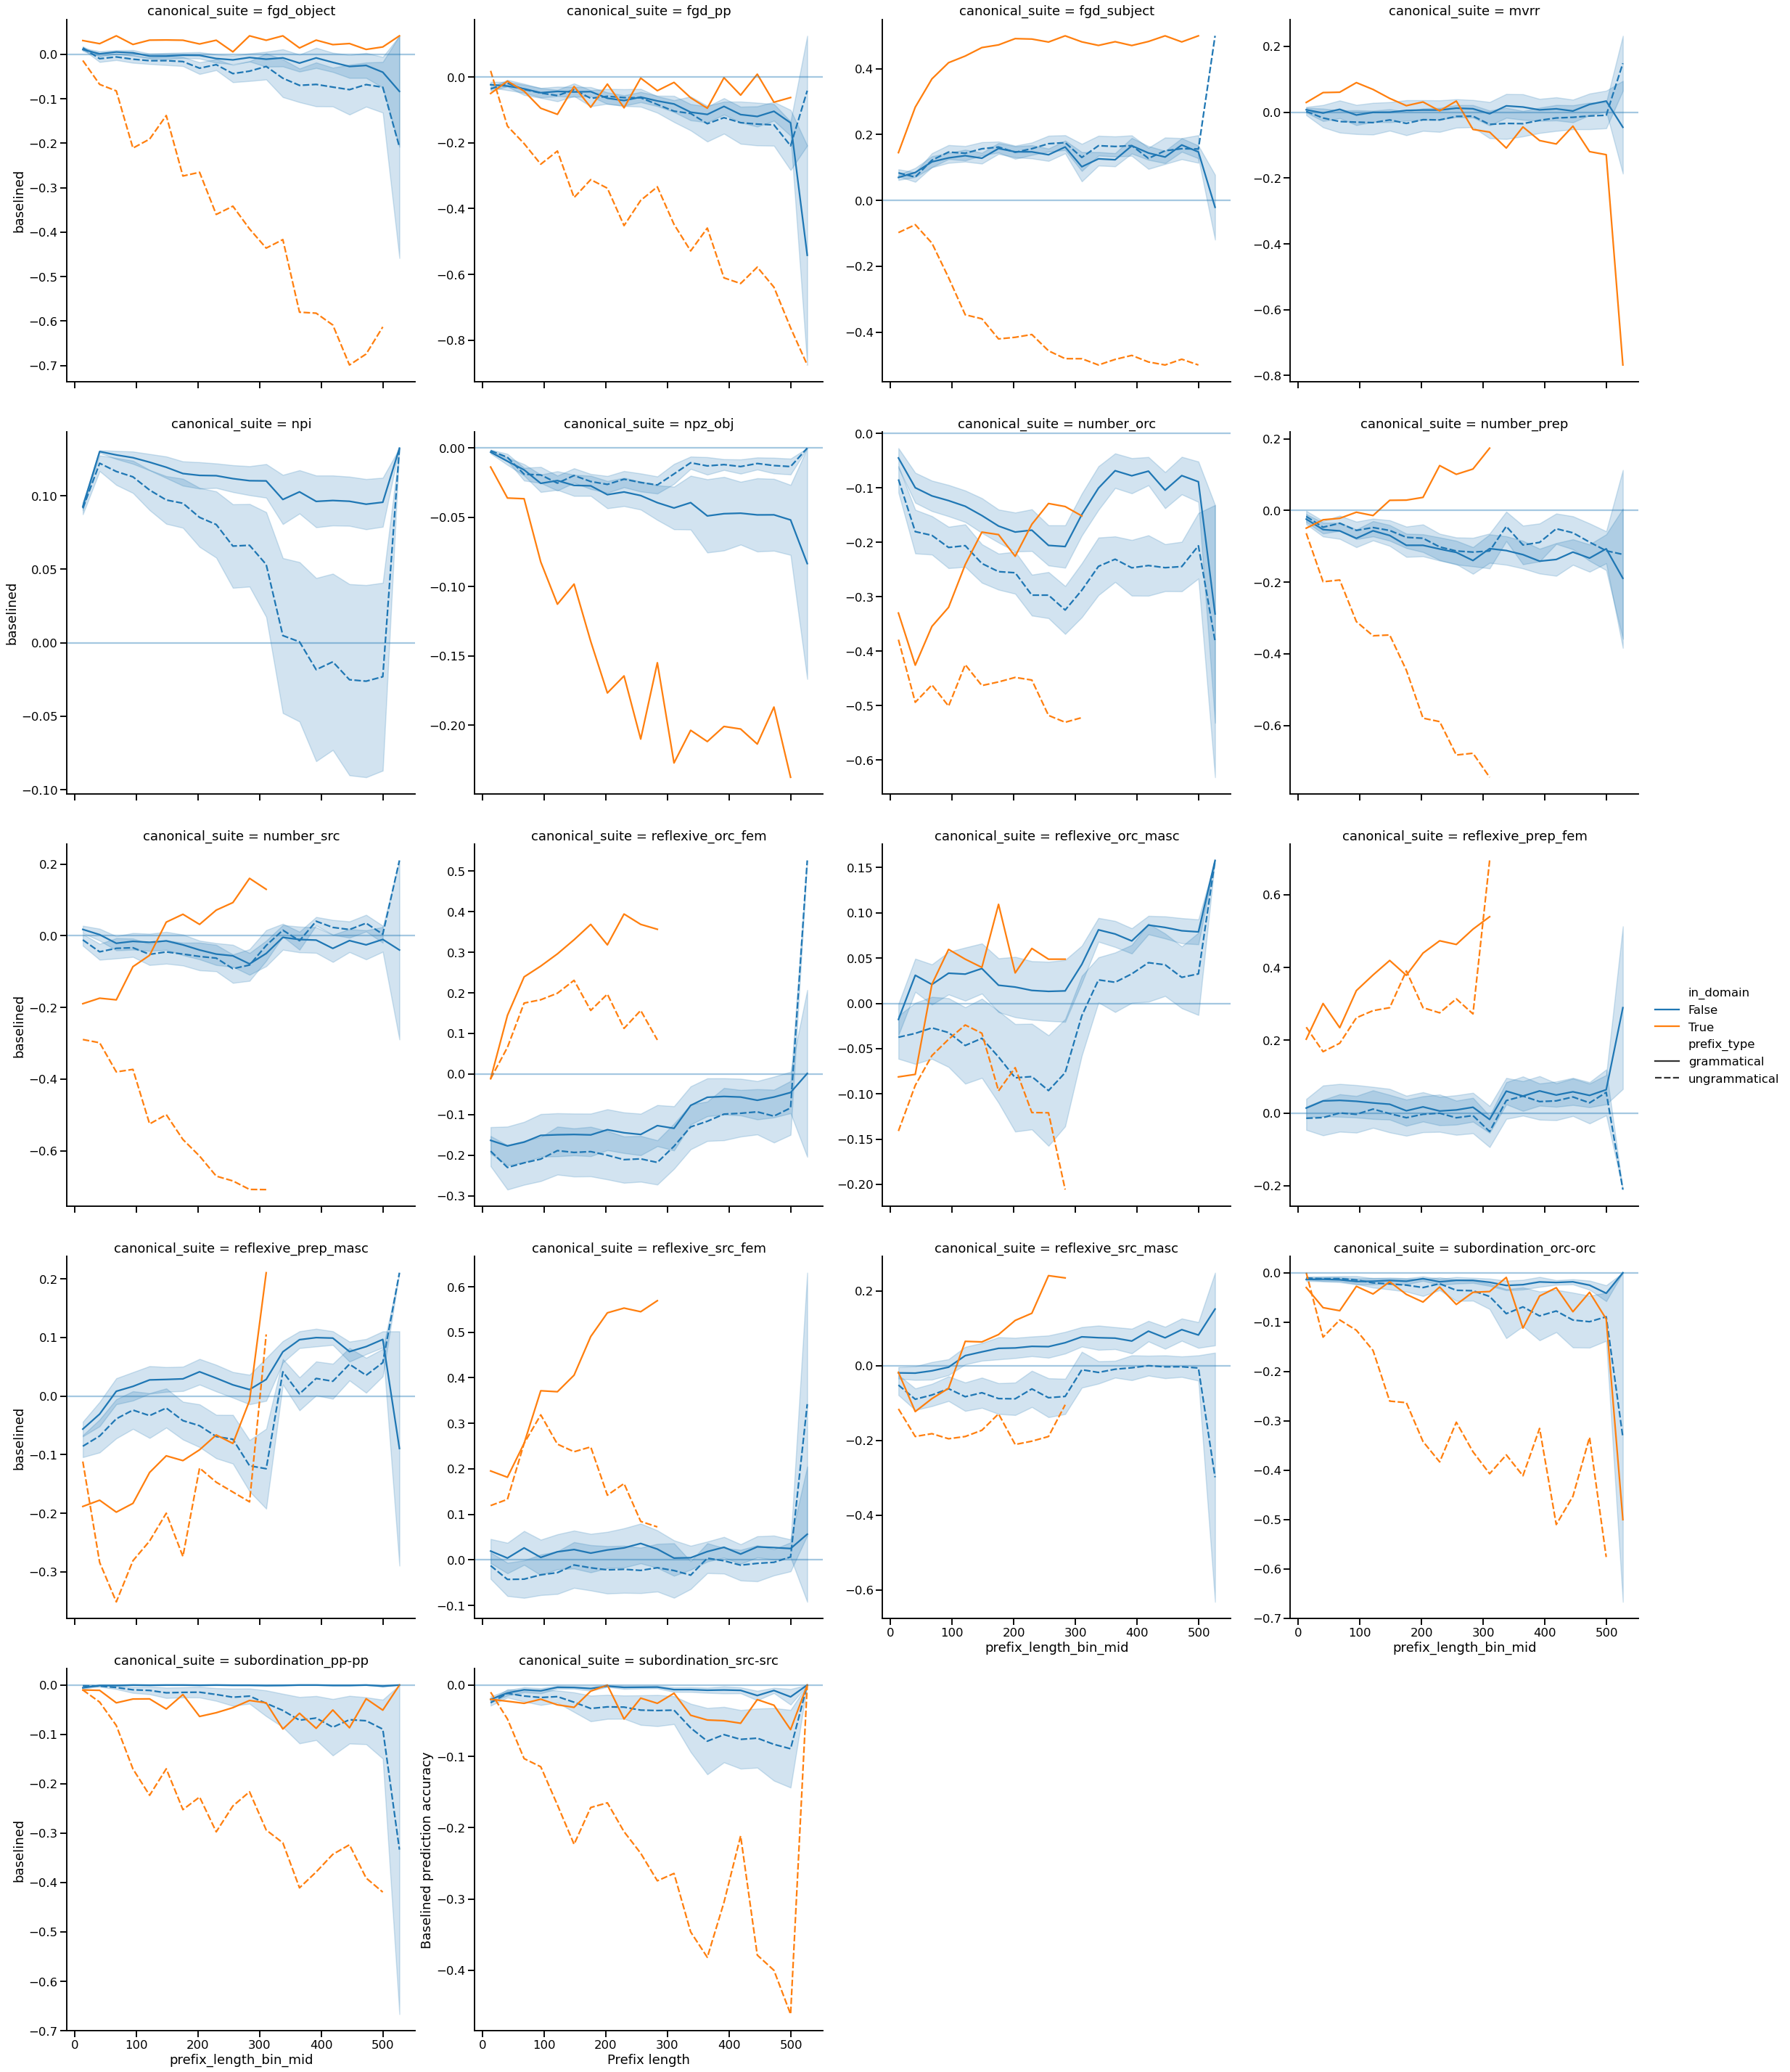

In [47]:
g = sns.FacetGrid(data=prediction_summaries[prediction_summaries.prediction == "prediction_ALL"],
                  height=8, col="canonical_suite", col_wrap=4,
                  hue_order=[True, False], sharey=False)
g.map_dataframe(sns.lineplot, x="prefix_length_bin_mid", y="baselined", hue="in_domain",
                style="prefix_type", style_order=sorted(prediction_summaries.prefix_type.unique()),
                errorbar="se")
g.add_legend()

plt.xlabel("Prefix length")
plt.ylabel("Baselined prediction accuracy")

for ax in g.axes.ravel():
    ax.axhline(0, alpha=0.4)

# if SAVE_FIGURES:
#     g.savefig(FIGURE_DIR / "prediction_accuracy.prefix_length_bin.pdf")
#     plt.close()

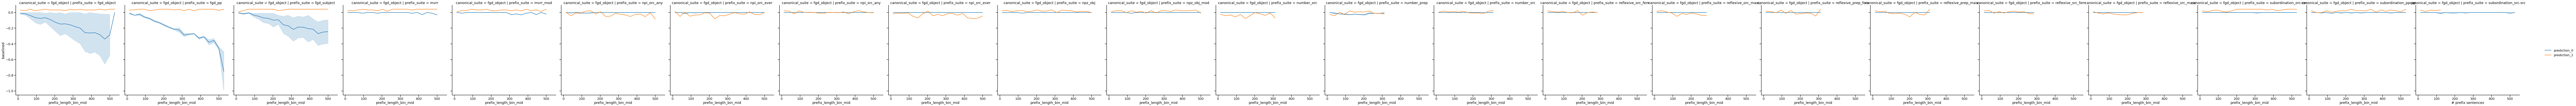

In [25]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=prediction_summaries.iloc[:1000], height=8, row="canonical_suite", col="prefix_suite")
    g.map(sns.lineplot, "prefix_length_bin_mid", "baselined", "prediction")
    g.add_legend()

    plt.xlabel("Prefix length")
    plt.ylabel("Baselined prediction accuracy")
    
    # if SAVE_FIGURES:
    #     g.savefig(FIGURE_DIR / "prediction_accuracy.prefix_length_bin.pdf")
    #     plt.close()

## Cross-suite prefixing analysis

In [34]:
def get_best_prediction_performance(prefixed_suite):
    return prefixed_suite.groupby("num_prefix_sentences")[["prediction_ALL"]].mean().max()
cross_perfs = prediction_df.groupby(["model", "prefix_type", "suite", "prefix_suite"]).progress_apply(get_best_prediction_performance)
cross_perfs

  0%|          | 0/4662 [00:00<?, ?it/s]

prediction_ALL
model    prefix_type   suite                 prefix_suite                         
gpt2     grammatical   fgd_object            fgd_object                   1.000000
                                             fgd_pp                       0.983607
                                             fgd_subject                  1.000000
                                             mvrr                         1.000000
                                             mvrr_mod                     1.000000
...                                                                            ...
opt-6.7b ungrammatical subordination_src-src reflexive_prep_fem           1.000000
                                             reflexive_prep_masc          1.000000
                                             reflexive_src_fem            1.000000
                                             reflexive_src_masc           1.000000
                                             subordination_orc-orc        0.860000

[4662 rows x 1 columns]

In [95]:
def plot_cross_perfs(cross_perfs: pd.DataFrame, **kwargs):
    cross_perfs = cross_perfs.sort_index(axis=0).sort_index(axis=1)
    f, axs = plt.subplots(len(cross_perfs.columns), 1, figsize=(30, 30))
    if not isinstance(axs, list):
        axs = [axs]
    for ax, col_name in zip(axs, cross_perfs.columns):
        sns.heatmap(cross_perfs[col_name].unstack(), ax=ax, annot=True, **kwargs)
        ax.set_title(col_name)
    plt.tight_layout()
    return f, axs

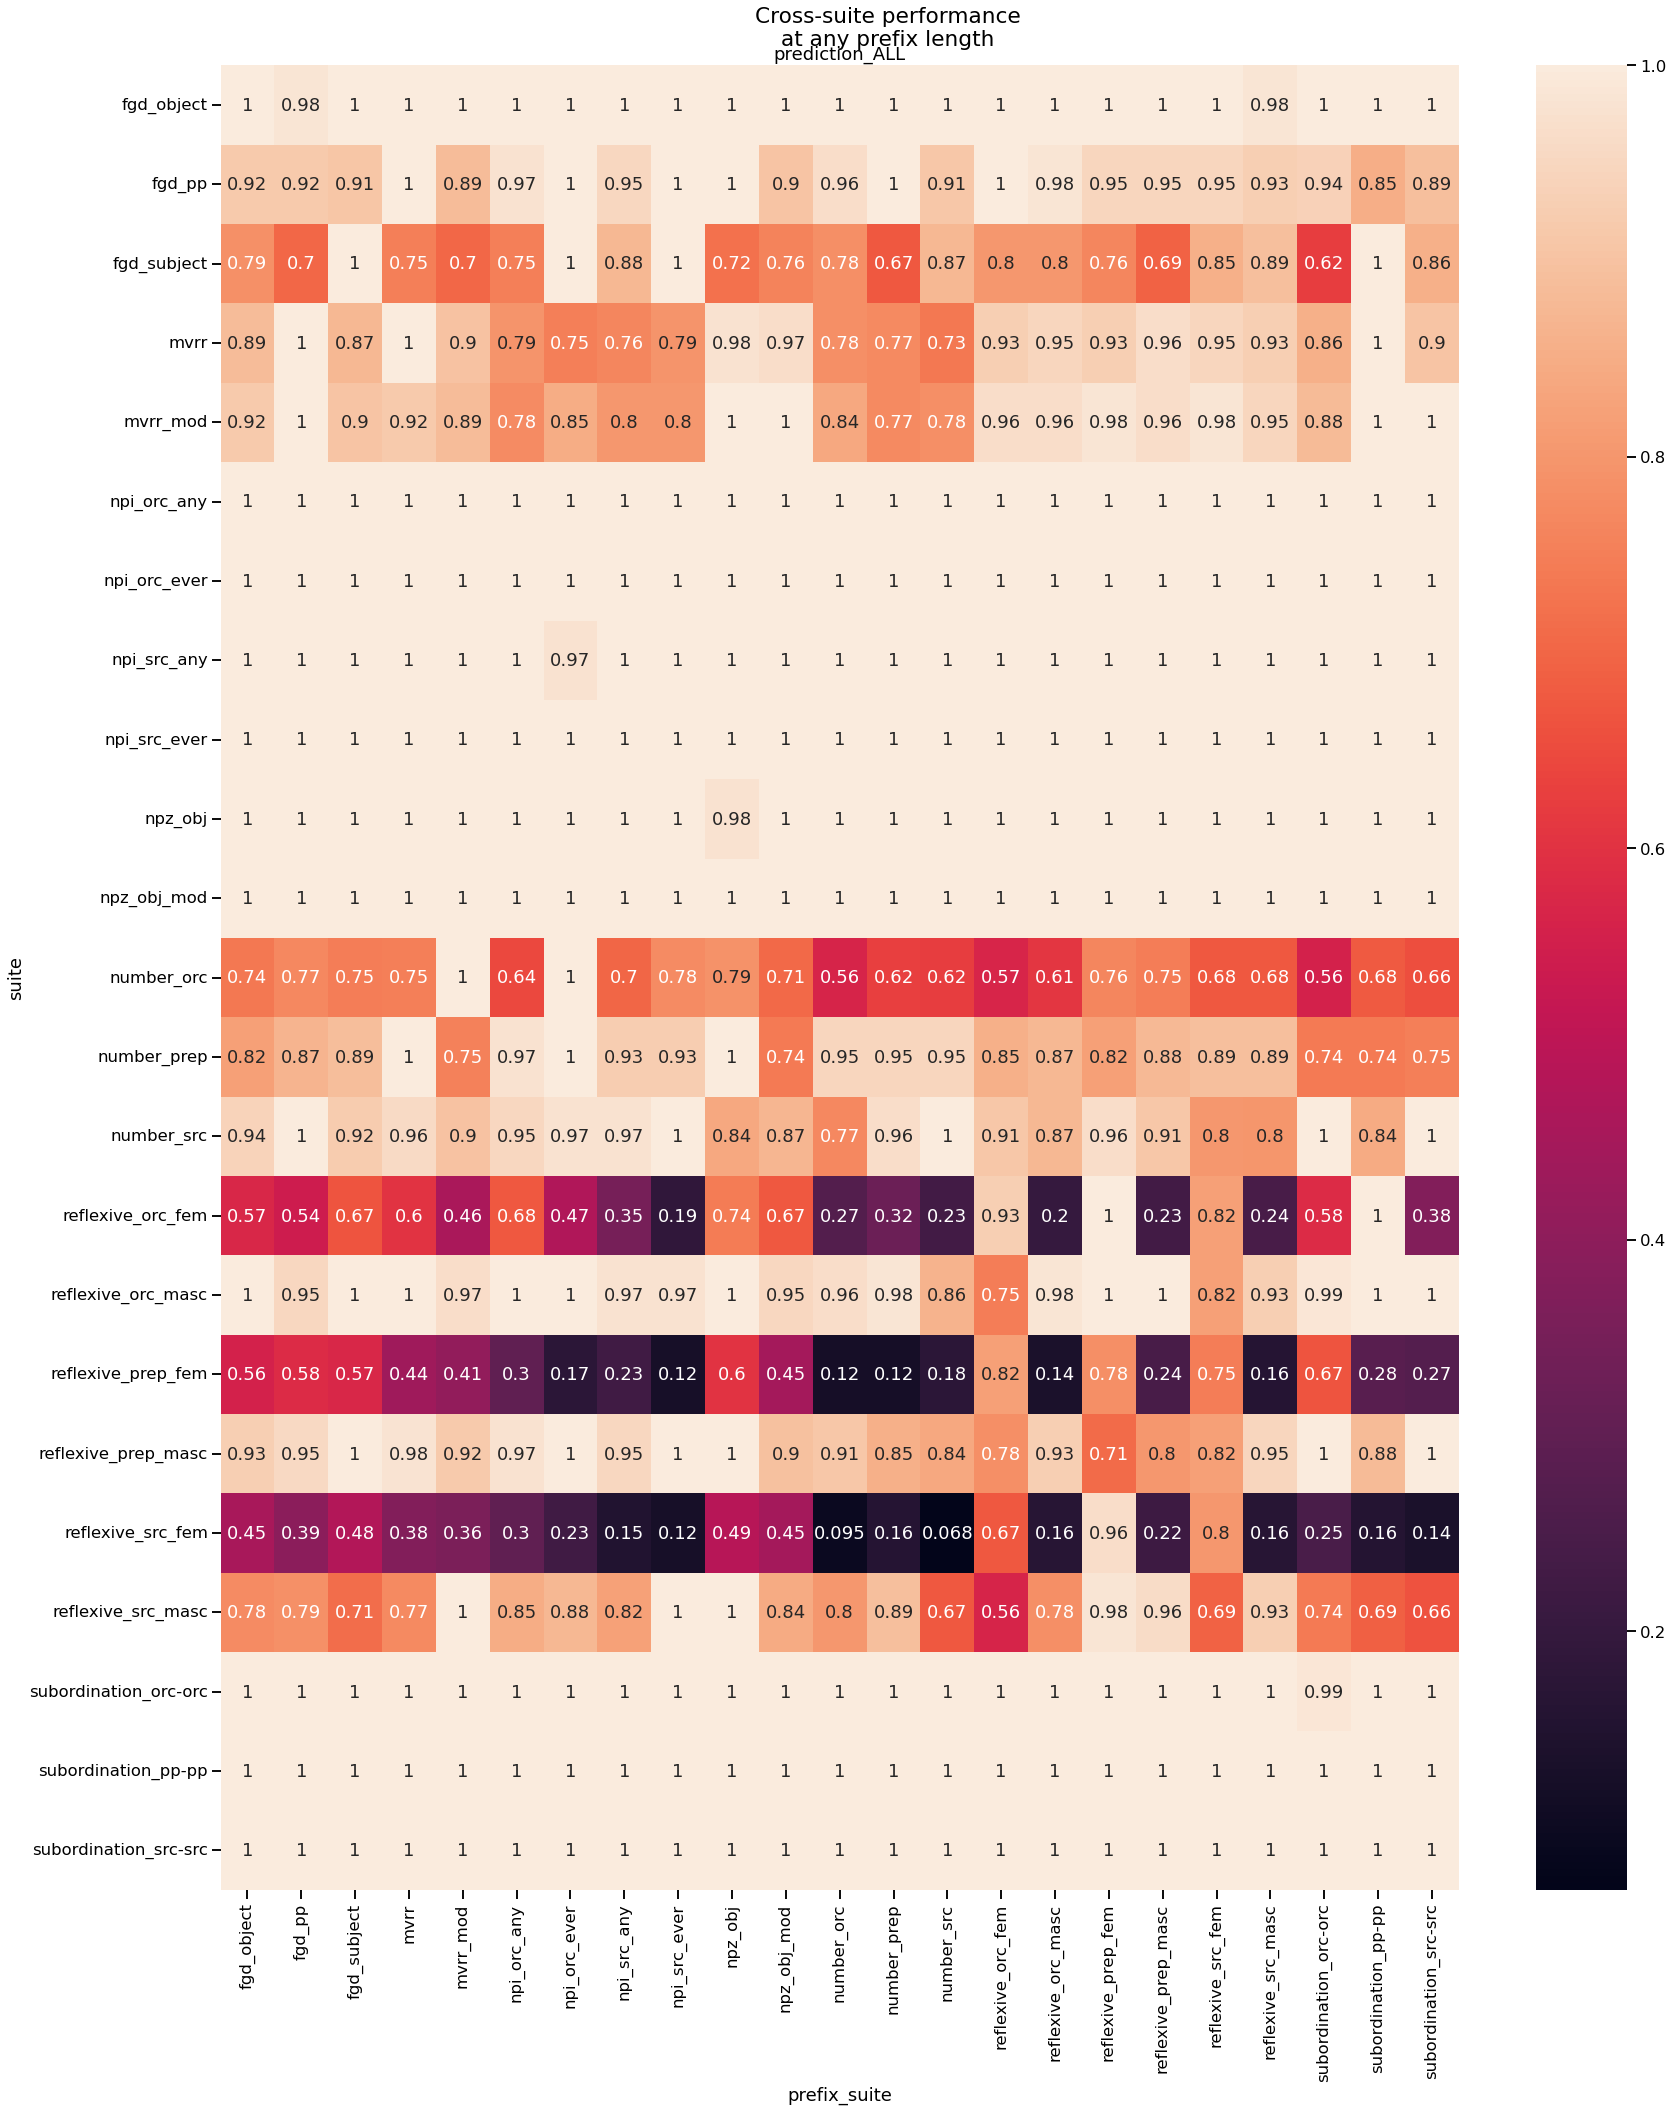

In [80]:
f, axs = plot_cross_perfs(cross_perfs.loc["gpt2"].loc["grammatical"])
f.suptitle("Cross-suite performance\nat any prefix length")
plt.tight_layout()

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / "cross_suite.max.pdf")

### Redo with matched lengths

In [81]:
# Pick the minimum number of prefix sentences for which all suite/prefix-suite combinations have data
max_sentences = prediction_df.groupby(["suite", "prefix_suite"]).num_prefix_sentences.max().min()
print(max_sentences)

cross_perfs_maxlen = prediction_df[prediction_df.prefix_type == "grammatical"].groupby(["model", "suite", "prefix_suite"]).progress_apply(lambda xs: xs.loc[xs.num_prefix_sentences == max_sentences, prediction_cols].mean())
cross_perfs_maxlen.head()

14.0


  0%|          | 0/2549 [00:00<?, ?it/s]

prediction_0  prediction_1  prediction_2  \
model suite      prefix_suite                                             
gpt2  fgd_object fgd_object        1.000000      0.983607           NaN   
                 fgd_pp            0.786885      1.000000           NaN   
                 fgd_subject       0.968254      0.984127           NaN   
                 mvrr              0.979167      1.000000           NaN   
                 mvrr_mod          1.000000      0.983607           NaN   

                               prediction_ALL  
model suite      prefix_suite                  
gpt2  fgd_object fgd_object          0.983607  
                 fgd_pp              0.786885  
                 fgd_subject         0.952381  
                 mvrr                0.979167  
                 mvrr_mod            0.983607

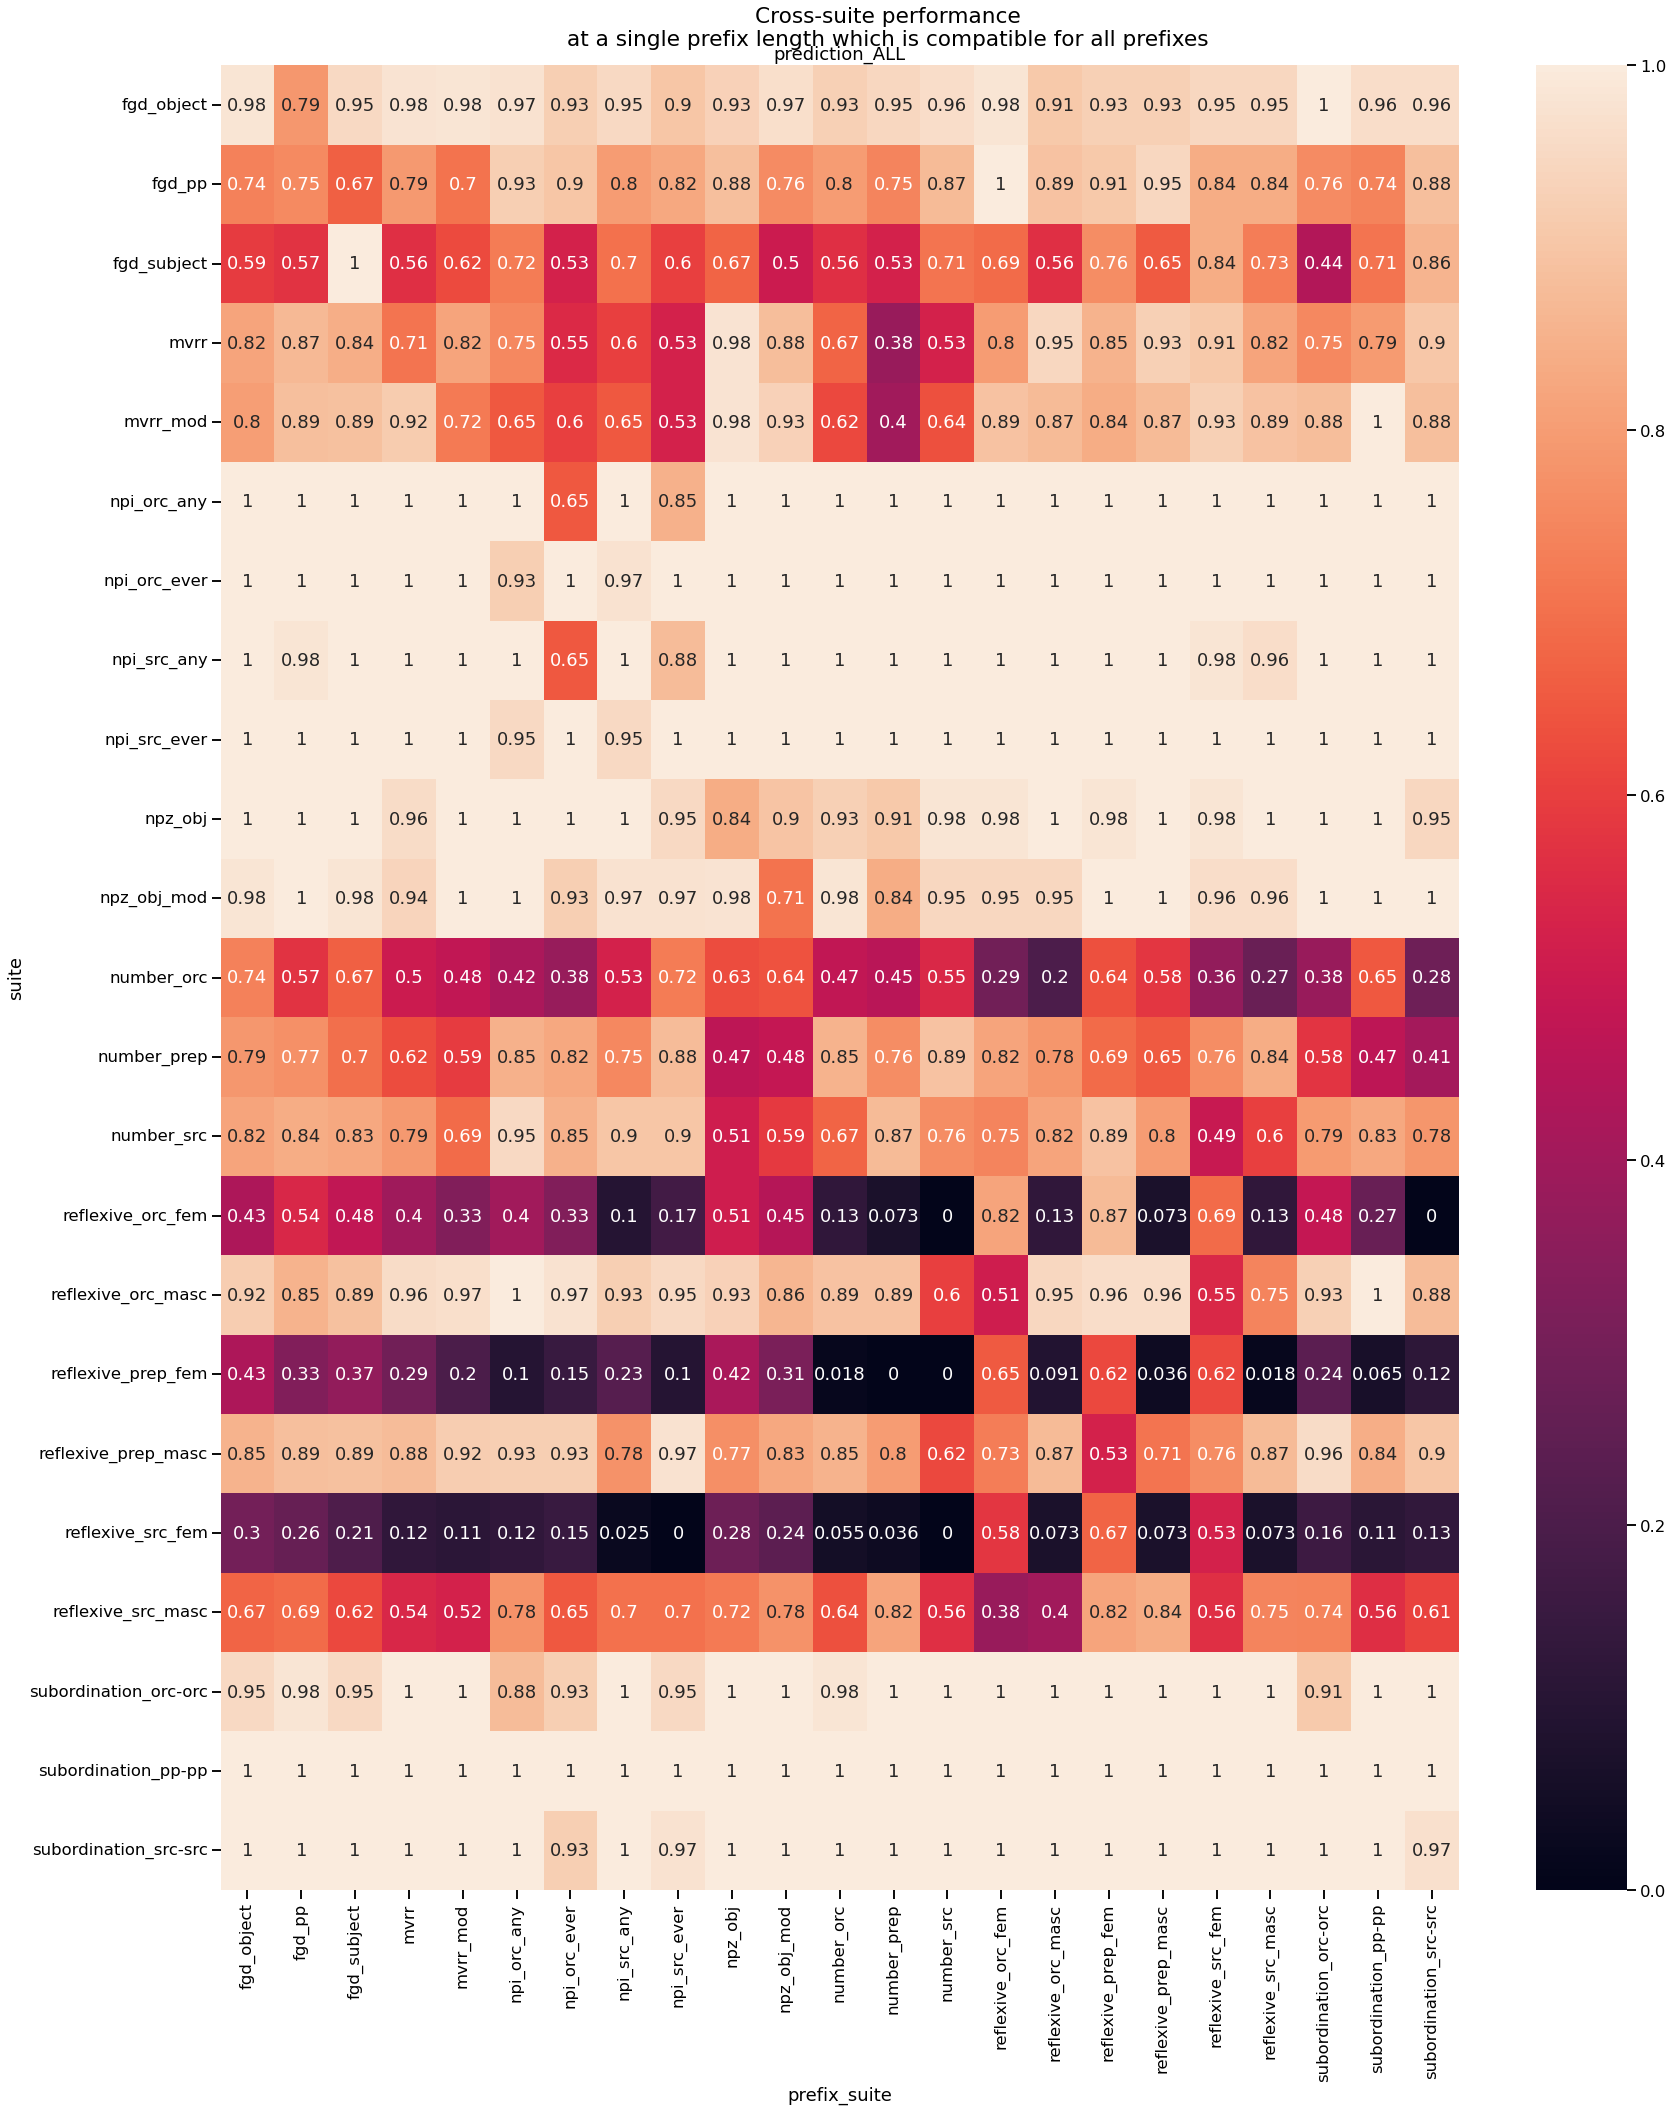

In [82]:
f, axs = plot_cross_perfs(cross_perfs_maxlen.loc["gpt2", ["prediction_ALL"]])
f.suptitle("Cross-suite performance\nat a single prefix length which is compatible for all prefixes")
plt.tight_layout()

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / f"cross_suite.len-{int(max_sentences)}.pdf")

### Plot changes from baseline rather than absolute accuracy, at maximum and at matched lengths

In [83]:
baseline_perfs = prediction_df[prediction_df.prefix_length == 0].reset_index().groupby(["model", "suite"]).apply(lambda xs: xs[xs.prefix_suite == xs.suite][prediction_cols].mean())
baseline_perfs

prediction_0  prediction_1  prediction_2  \
model    suite                                                             
gpt2     fgd_object                 1.000000      0.958333           NaN   
         fgd_pp                     0.916667      0.958333           NaN   
         fgd_subject                0.625000      0.875000           NaN   
         mvrr                       1.000000      0.892857      0.857143   
         mvrr_mod                   1.000000      0.821429      0.750000   
...                                      ...           ...           ...   
opt-6.7b reflexive_src_fem          0.473684      1.000000           NaN   
         reflexive_src_masc         0.947368      0.894737           NaN   
         subordination_orc-orc      0.956522      1.000000           NaN   
         subordination_pp-pp        1.000000      1.000000           NaN   
         subordination_src-src      1.000000      0.956522           NaN   

                                prediction_ALL  
model    suite                                  
gpt2     fgd_object                   0.958333  
         fgd_pp                       0.875000  
         fgd_subject                  0.500000  
         mvrr                         0.785714  
         mvrr_mod                     0.750000  
...                                        ...  
opt-6.7b reflexive_src_fem            0.473684  
         reflexive_src_masc           0.842105  
         subordination_orc-orc        0.956522  
         subordination_pp-pp          1.000000  
         subordination_src-src        0.956522  

[115 rows x 4 columns]

In [84]:
def get_best_prediction_improvement_pct(rows, matched_lengths=True):
    model, suite, prefixed_suite = rows.name
    
    if matched_lengths:
        rows = rows[rows.num_prefix_sentences == max_sentences]
    mean_perfs = rows.groupby("num_prefix_sentences")[prediction_cols].mean()
    
    try:
        baseline_perf = baseline_perfs.loc[model].loc[suite]
    except KeyError:
        baseline_perf = np.nan
        
    diff_of_means = mean_perfs - baseline_perf
    max_diff = diff_of_means.max()
    return max_diff / baseline_perf * 100

In [88]:
cross_improvement_pcts = prediction_df[prediction_df.prefix_type == "grammatical"].groupby(["model", "suite", "prefix_suite"]).progress_apply(get_best_prediction_improvement_pct, matched_lengths=False)

  0%|          | 0/2549 [00:00<?, ?it/s]

In [99]:
cross_improvement_pcts

prediction_0  \
model    suite                 prefix_suite                          
gpt2     fgd_object            fgd_object                 0.000000   
                               fgd_pp                    -1.639344   
                               fgd_subject                0.000000   
                               mvrr                       0.000000   
                               mvrr_mod                   0.000000   
...                                                            ...   
opt-6.7b subordination_src-src reflexive_src_fem          0.000000   
                               reflexive_src_masc         0.000000   
                               subordination_orc-orc      0.000000   
                               subordination_pp-pp        0.000000   
                               subordination_src-src      0.000000   

                                                      prediction_1  \
model    suite                 prefix_suite                          
gpt2     fgd_object            fgd_object                 4.347826   
                               fgd_pp                     4.347826   
                               fgd_subject                4.347826   
                               mvrr                       4.347826   
                               mvrr_mod                   4.347826   
...                                                            ...   
opt-6.7b subordination_src-src reflexive_src_fem          4.545455   
                               reflexive_src_masc         4.545455   
                               subordination_orc-orc      4.545455   
                               subordination_pp-pp        4.545455   
                               subordination_src-src      4.545455   

                                                      prediction_2  \
model    suite                 prefix_suite                          
gpt2     fgd_object            fgd_object                      NaN   
                               fgd_pp                          NaN   
                               fgd_subject                     NaN   
                               mvrr                            NaN   
                               mvrr_mod                        NaN   
...                                                            ...   
opt-6.7b subordination_src-src reflexive_src_fem               NaN   
                               reflexive_src_masc              NaN   
                               subordination_orc-orc           NaN   
                               subordination_pp-pp             NaN   
                               subordination_src-src           NaN   

                                                      prediction_ALL  
model    suite                 prefix_suite                           
gpt2     fgd_object            fgd_object                   4.347826  
                               fgd_pp                       2.637206  
                               fgd_subject                  4.347826  
                               mvrr                         4.347826  
                               mvrr_mod                     4.347826  
...                                                              ...  
opt-6.7b subordination_src-src reflexive_src_fem            4.545455  
                               reflexive_src_masc           4.545455  
                               subordination_orc-orc        4.545455  
                               subordination_pp-pp          4.545455  
                               subordination_src-src       -2.243211  

[2549 rows x 4 columns]

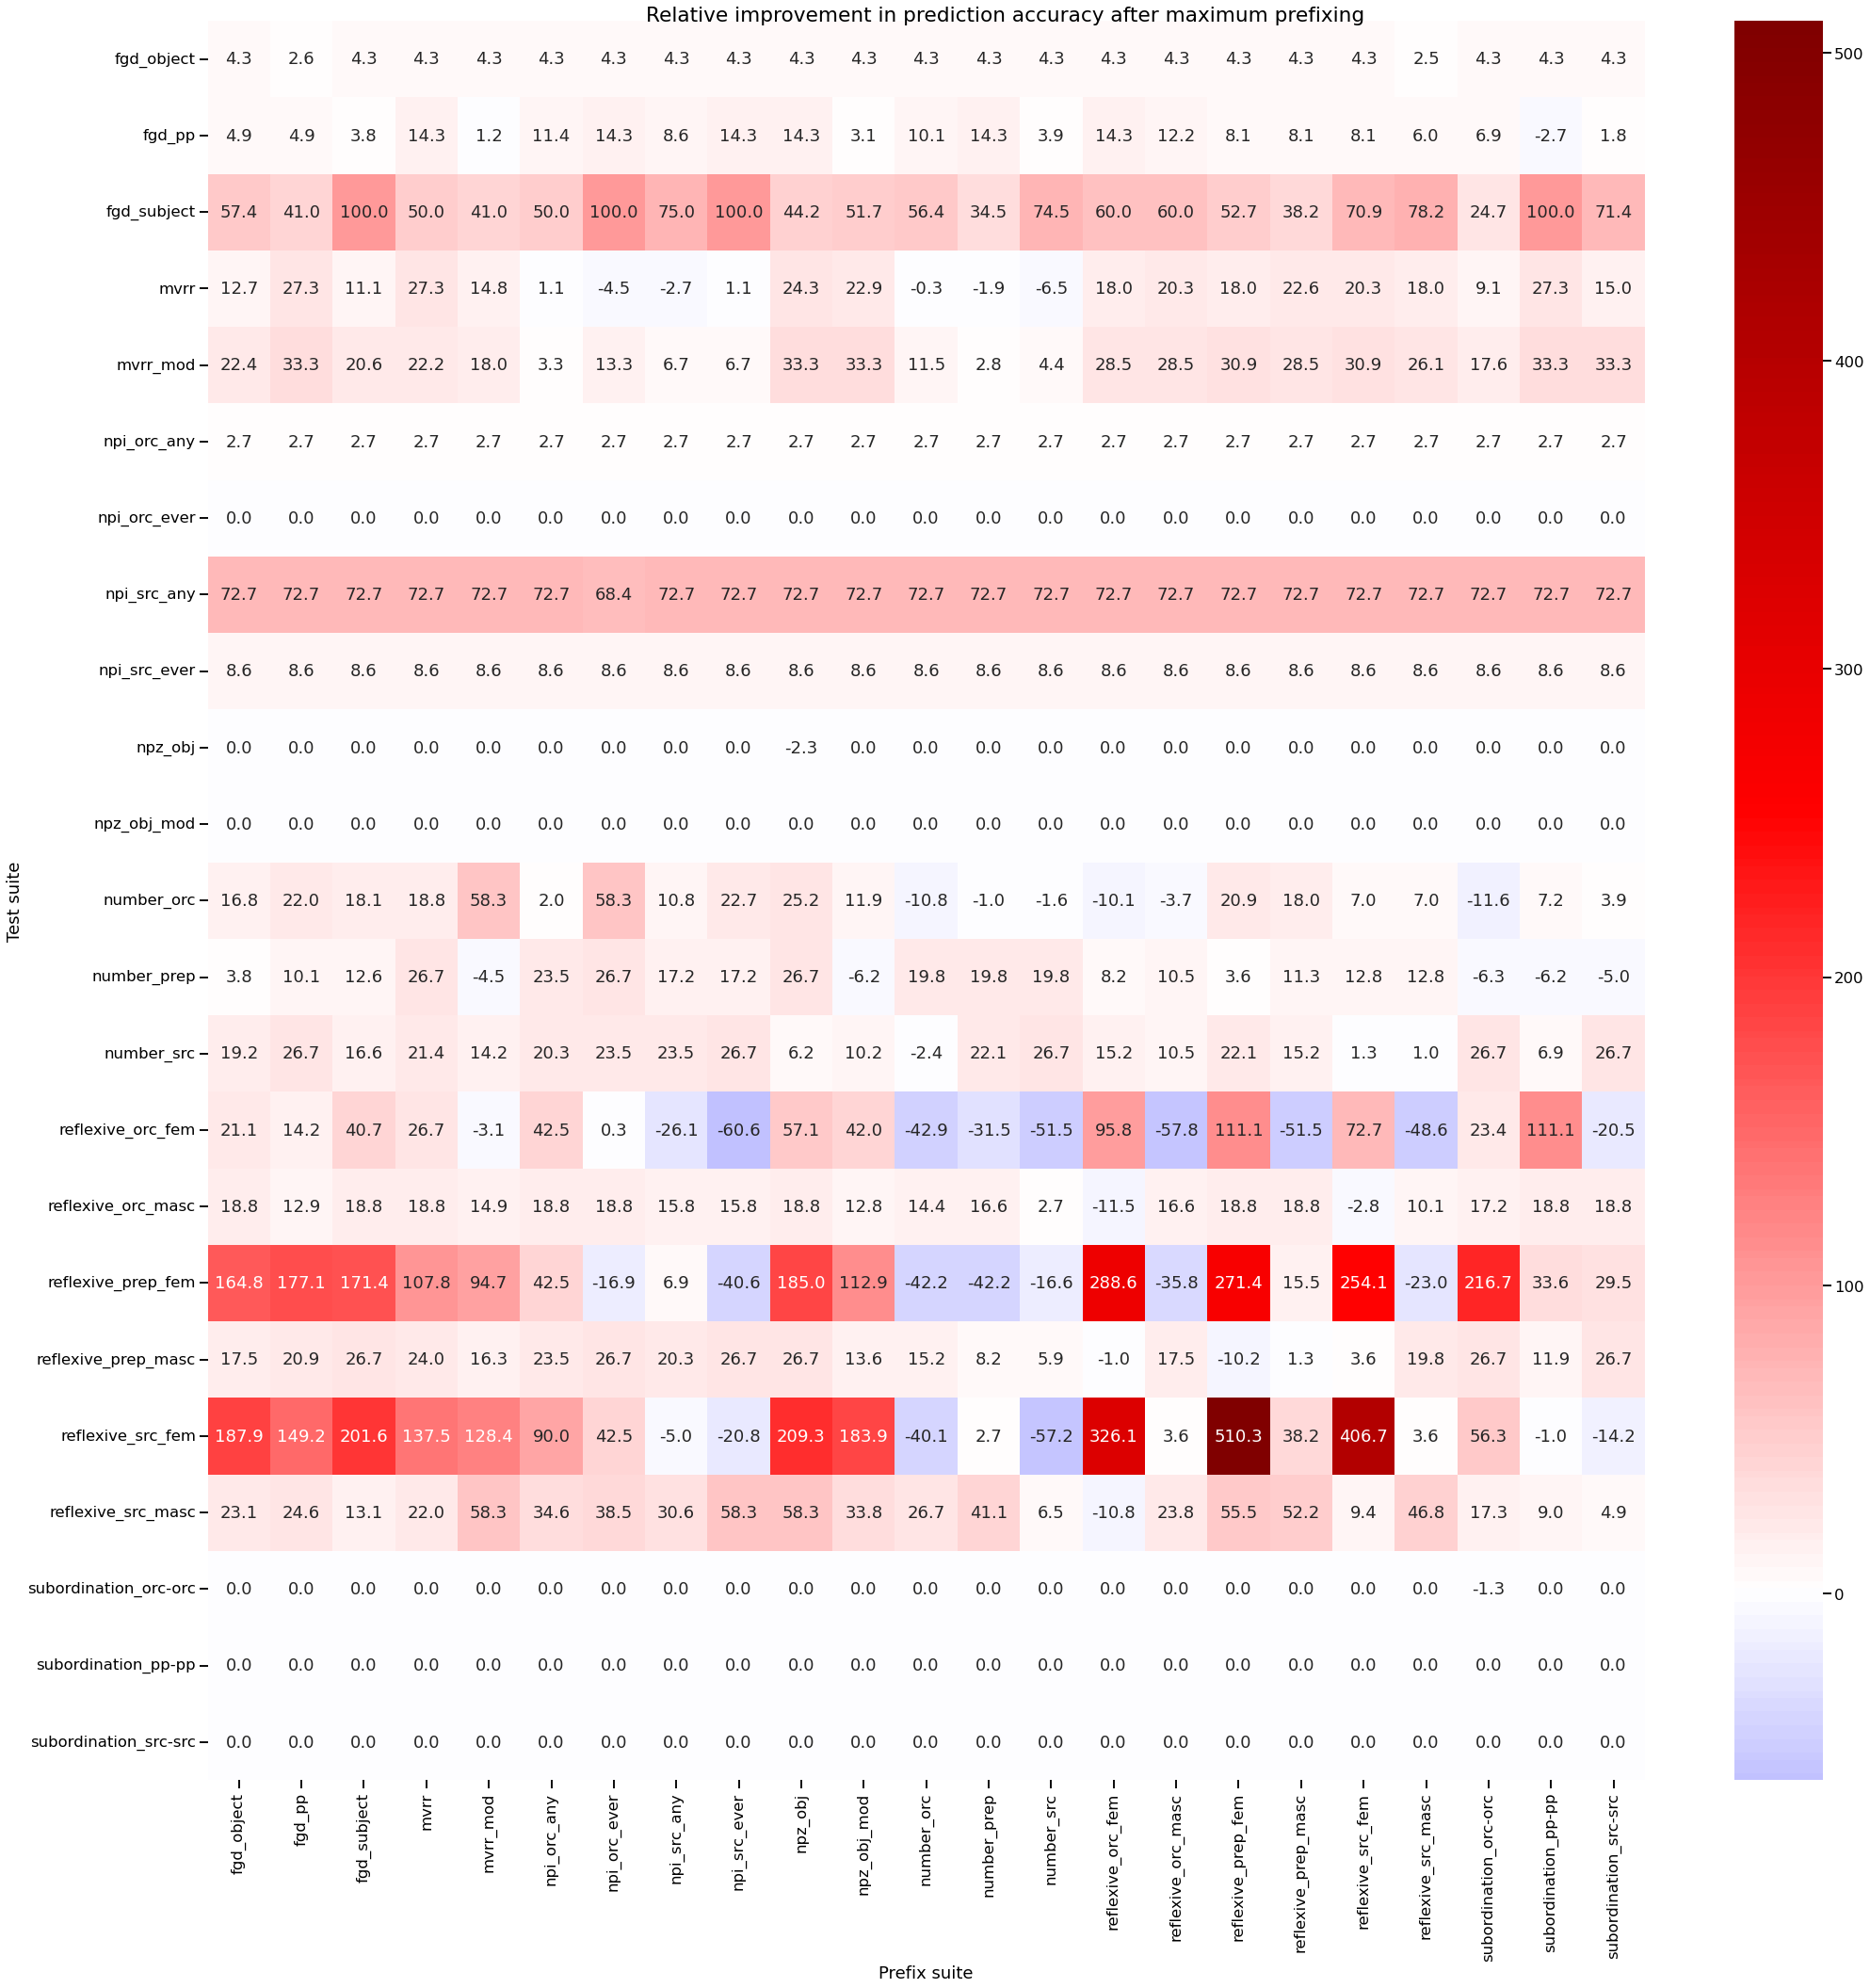

In [104]:
f, axs = plot_cross_perfs(cross_improvement_pcts.loc["gpt2", ["prediction_ALL"]], center=0, cmap="seismic", fmt=".1f")

plt.xlabel("Prefix suite")
plt.ylabel("Test suite")
axs[0].set_title("")
plt.suptitle("Relative improvement in prediction accuracy after maximum prefixing")
plt.subplots_adjust(hspace=0.2)
plt.tight_layout()

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / f"cross_suite_pcts.max.pdf")

In [86]:
cross_improvement_pcts_maxlen.max()

prediction_0      383.636364
prediction_1       26.666667
prediction_2             NaN
prediction_ALL    341.071429
dtype: float64

  0%|          | 0/2549 [00:00<?, ?it/s]

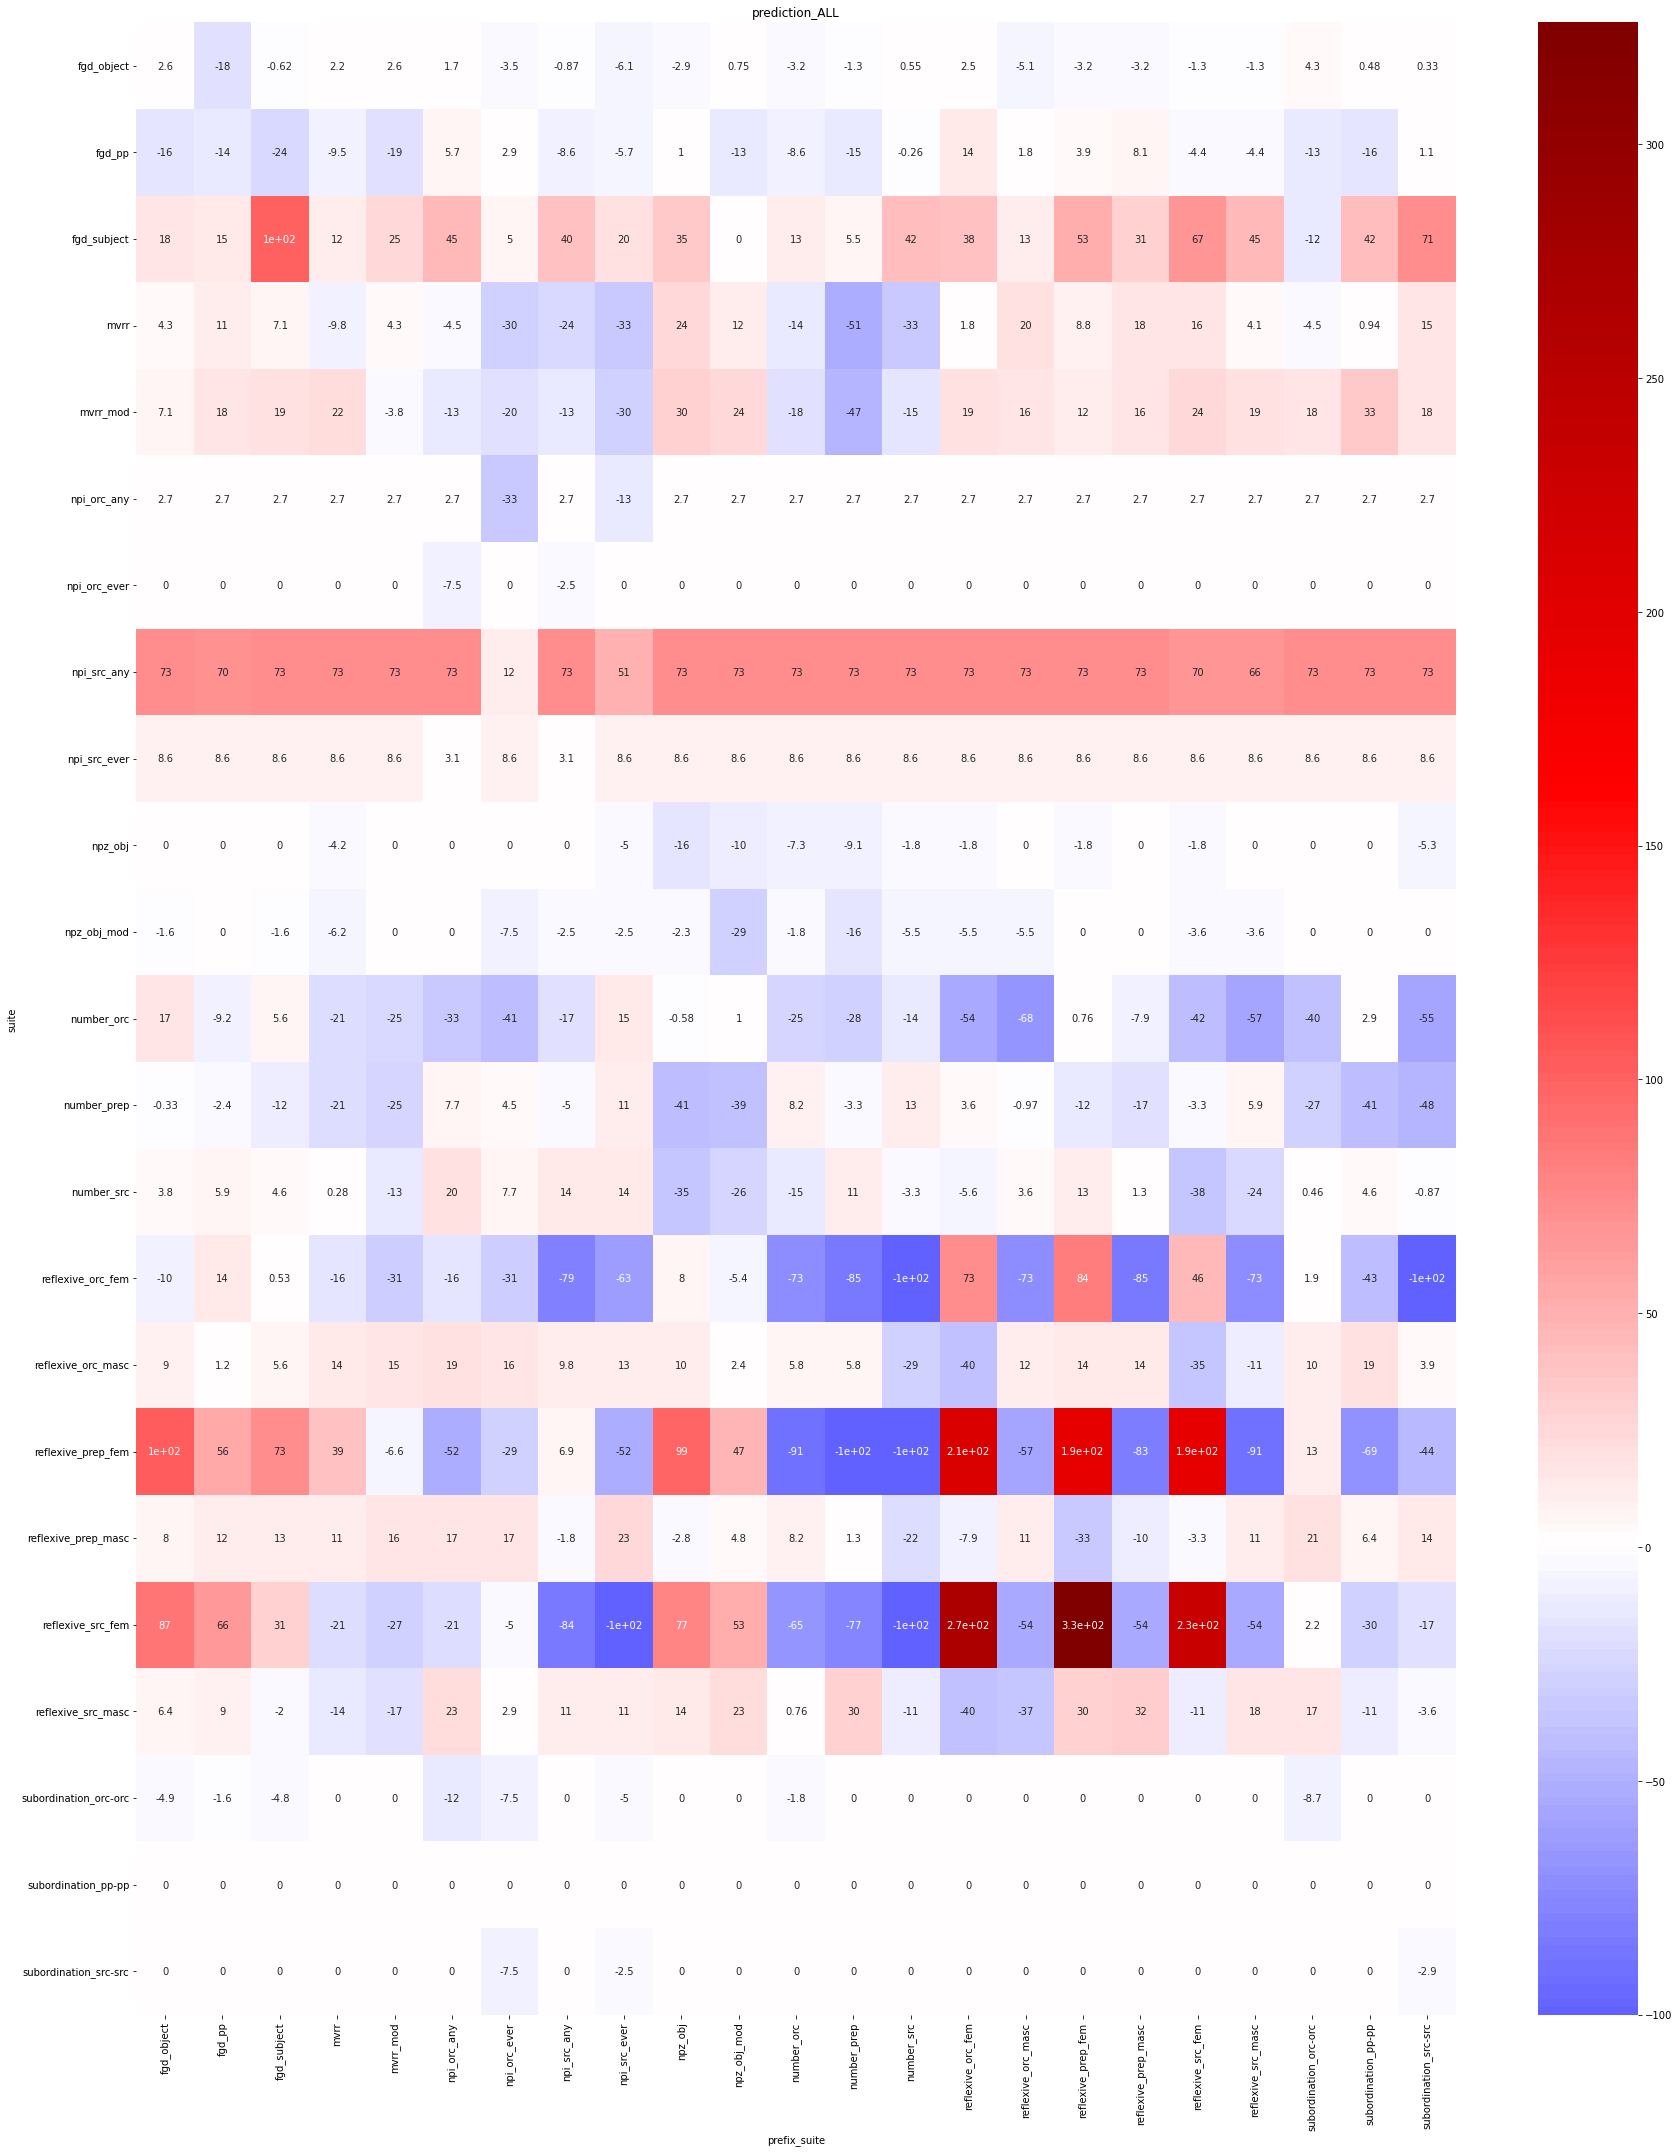

In [64]:
cross_improvement_pcts_maxlen = prediction_df[prediction_df.prefix_type == "grammatical"].groupby(["model", "suite", "prefix_suite"]).progress_apply(get_best_prediction_improvement_pct)
f, axs = plot_cross_perfs(cross_improvement_pcts_maxlen.loc["gpt2", ["prediction_ALL"]], center=0, cmap="seismic")

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / f"cross_suite_pcts.len-{int(max_sentences)}.pdf")

In [ ]:
sns.clustermap(cross_improvement_pcts["prediction_ALL"].unstack())

## Margins

In [ ]:
def filter_critical_regions(suite_df):
    critical_strs = critical_region_strs[suite_df.canonical_suite.iloc[0]]
    is_critical = suite_df.region_number.astype(str).str.cat(suite_df.condition, " ").isin(critical_strs)
    return suite_df[is_critical]

critical_region_df = region_df.groupby(["suite", "canonical_suite"], as_index=False) \
    .apply(filter_critical_regions)
critical_region_df

In [ ]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=critical_region_df, height=8, row="canonical_suite", col="prefix_suite", sharey=False)
    g.map(sns.lineplot, "prefix_length_bin", "value", "condition")
    for ax in g.axes.ravel():
        ax.legend()

    plt.xticks(rotation=35)
    plt.legend(loc=(1.04,0))
    plt.xlabel("# prefix tokens (binned)")
    plt.ylabel("Raw surprisal")
    
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "surprisal.prefix_length_bin.pdf")
        plt.close()

In [ ]:
# g = sns.catplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", alpha=0.1,
#                 height=10)
# sns.lineplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", ax=g.ax, legend=False)

# plt.legend(loc=(1.04,0))
# plt.xlabel("# prefix sentences")
# plt.ylabel("Raw surprisal")

In [ ]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["region_number", "condition"]).value
    
    margins = pd.Series([rows.loc[ungrammatical] - rows.loc[grammatical]
                         for grammatical, ungrammatical in margin_spec])
    return margins

margin_sizes = critical_region_df.groupby(["suite", "prefix_suite", "item_number"]).apply(compute_margins)
margin_sizes = pd.merge(margin_sizes.reset_index(), prediction_df[meta_vars].reset_index(),
                        on=["suite", "prefix_suite", "item_number"])
margin_sizes

In [ ]:
# Prefer binned figure below.

# sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"], var_name="Prediction"),
#              x="prefix_length", y="value", hue="Prediction")

# plt.legend(loc=(1.04, 0))
# plt.axhline(0, color="gray", linestyle="--")
# plt.xlabel("# prefix tokens")
# plt.ylabel("Grammaticality margin (bits)")

In [ ]:
if RENDER_ALL_FIGURES:
    margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
    to_plot = margin_sizes.melt(id_vars=meta_vars + ["prefix_suite"],
                                value_vars=[0, 1], var_name="Prediction")
    g = sns.catplot(data=to_plot, row="canonical_suite", col="prefix_suite",
                    x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
    g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

    for ax in g.axes.flat:
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xticks(ax.get_xticks(), rotation=35)
        ax.set_xlabel("# prefix tokens (binned)")
        ax.set_ylabel("Grammaticality margin (bits)")
        
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "margins.prefix_length_bin.pdf")
        plt.close()

In [ ]:
# # DEV recompute predictions as a sanity check
# recompute_preds = margin_sizes.assign(**{f"correct_{idx}": margin_sizes[idx] > 0
#                                          for idx in [col for col in margin_sizes.columns if isinstance(col, int)]})

In [ ]:
# sns.lineplot(data=recompute_preds[["prefix_length_bin", "correct_0", "correct_1"]].melt(id_vars=["prefix_length_bin"]),
#              x="prefix_length_bin", y="value", hue="variable")

In [ ]:
# # recompute_preds[recompute_preds.prefix_length == 0].groupby("canonical_suite").correct.mean()
# recompute_preds[recompute_preds.prefix_length == 0][["correct_0", "correct_1"]].melt().groupby("variable").value.mean()

## Total probability margins

In [ ]:
total_surprisals = region_df.groupby(["suite", "canonical_suite", "prefix_suite", "item_number", "condition"]).value.sum().reset_index()
total_surprisals

In [ ]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["condition"]).value
    return pd.Series([rows.loc[ungrammatical_cond] - rows.loc[grammatical_cond]
                      for (_, grammatical_cond), (_, ungrammatical_cond) in margin_spec])

total_surprisal_margins = total_surprisals.groupby(["suite", "prefix_suite", "item_number"]).apply(compute_margins)
total_surprisal_margins

In [ ]:
# Bring back metadata
total_surprisal_margins = pd.merge(total_surprisal_margins.reset_index(), prediction_df[meta_vars].reset_index(),
                                   on=["suite", "prefix_suite", "item_number"])

In [ ]:
if RENDER_ALL_FIGURES:
    to_plot = total_surprisal_margins.melt(id_vars=["prefix_length_bin", "canonical_suite", "prefix_suite"],
                                           value_vars=[0, 1], var_name="Prediction")
    g = sns.catplot(data=to_plot, row="canonical_suite", col="prefix_suite",
                    x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
    g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

    for ax in g.axes.flat:
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xticks(ax.get_xticks(), rotation=35)
        ax.set_xlabel("# prefix tokens (binned)")
        ax.set_ylabel("Grammaticality margin (bits)")
        
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "total_surprisal_margin.prefix_length_bin.pdf")
        plt.close()

## Save results data

In [8]:
prediction_df.to_csv(RESULTS_DIR / "predictions.csv")
# region_df.to_csv(RESULTS_DIR / "regions.csv", index=False)

cross_perfs.to_csv(RESULTS_DIR / "cross_suite.max.csv")
cross_perfs_maxlen.to_csv(RESULTS_DIR / f"cross_suite.len-{int(max_sentences)}.csv")
cross_improvement_pcts.to_csv(RESULTS_DIR / "cross_suite_pcts.max.csv")
cross_improvement_pcts_maxlen.to_csv(RESULTS_DIR / f"cross_suite_pcts.len-{int(max_sentences)}.csv")

NameError: name 'cross_perfs' is not defined

In [ ]:
# critical_region_df.to_csv(RESULTS_DIR / "critical_regions.csv")
margin_sizes.to_csv(RESULTS_DIR / "margins.csv")
total_surprisals.to_csv(RESULTS_DIR / "total_surprisals.csv")
total_surprisal_margins.to_csv(RESULTS_DIR / "total_surprisal_margins.csv")